In [2]:
from datetime import datetime
import numpy as np
import os
os.environ['MPLCONFIGDIR'] = "/wrk-vakka/users/hajaalin/tmp_mplconfigdir"
from matplotlib import pyplot as plt
%matplotlib inline
from pathlib import Path
import shap
import sys

from load_data_tsc import load_data
from utility import parse_config

paths = "/proj/hajaalin/Projects/n_track_ML/scripts/tsc/paths.yml"
paths = parse_config(paths)
    
# add InceptionTime source to Python path
src_inceptiontime = paths["src"]["inceptiontime"]
sys.path.insert(1, src_inceptiontime)
from cv_inceptiontime import inceptiontime_cv_repeat, get_standard_scaling, apply_standard_scaling
from utils.utils import readucr

# read the data 
data_dir = paths["data"]["dir"]
raw_data_file = paths["data"]["raw_data_file"]
fset = "all"
X, y, groups, features, datam, datan = load_data(Path(data_dir) / raw_data_file, fset, debug=True)





/proj/group/lmu/software/Miniconda3/py38_4.12.0/envs/tsc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


sklearn 1.1.1
sktime 0.10.1
Loaded data shape: (8398, 17)
Index(['file', 'serum', 'D', 'A', 'P', 'Dist', 'dt'], dtype='object')
X.shape: (289, 5, 28)
X.shape: (289, 28, 5)


# InceptionTime input example
Check the input format based on test data (https://github.com/hfawaz/InceptionTime#data). 

The order is (instance, timestep, feature).

In [3]:
file_name = \
'/proj/hajaalin/Projects/UCR_TS_Archive_2015/InlineSkate/InlineSkate_TRAIN'
print('test_ucr: ' + file_name)
x_train, y_train = readucr(file_name)
print('x_train.shape: ' + str(x_train.shape))
print('y_train.shape: ' + str(y_train.shape))
# https://github.com/hajaalin/InceptionTime/blob/d518ebe04c4404e49bdb056aa4aa00ea6ba9bd26/main.py#L35
if len(x_train.shape) == 2:  # if univariate
    # add a dimension to make it multivariate with one dimension
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print('x_train.shape: ' + str(x_train.shape))


test_ucr: /proj/hajaalin/Projects/UCR_TS_Archive_2015/InlineSkate/InlineSkate_TRAIN
x_train.shape: (100, 1882)
y_train.shape: (100,)
x_train.shape: (100, 1882, 1)


# Check data loading intermediates
## Multi-index dataframe

In [4]:
datam.head()

file  \
fp                                       frame                                          
210521_guide_1514i.sld_-_1514_i10_t35__0 2      210521_guide_1514i.sld_-_1514_i10_t35   
                                         3      210521_guide_1514i.sld_-_1514_i10_t35   
                                         4      210521_guide_1514i.sld_-_1514_i10_t35   
                                         5      210521_guide_1514i.sld_-_1514_i10_t35   
                                         6      210521_guide_1514i.sld_-_1514_i10_t35   

                                                serum         D           A  \
fp                                       frame                                
210521_guide_1514i.sld_-_1514_i10_t35__0 2          0  0.117854  301.848958   
                                         3          0  0.366152  301.458175   
                                         4          0  0.239324  300.937131   
                                         5          0  0.187754  301.492454   
                                         6          0  0.094312  301.979219   

                                                        P      Dist        dt  
fp                                       frame                                 
210521_guide_1514i.sld_-_1514_i10_t35__0 2      18.558761  1.773953  1.233874  
                                         3      18.709589  1.343691 -5.034635  
                                         4      18.634175  1.526075  2.334585  
                                         5      18.538193  1.435976 -3.523863  
                                         6      18.565617  1.441959  2.249091

## Nested dataframe

In [5]:
datan.head()

,file,serum,D,A,P,Dist,dt
0,2 210521_guide_1514i.sld_-_1514_i10_t35 3 ...,2 0 3 0 4 0 5 0 6 0 7 ...,2 0.117854 3 0.366152 4 0.239324 5...,2 301.848958 3 301.458175 4 300.93...,2 18.558761 3 18.709589 4 18.63417...,2 1.773953 3 1.343691 4 1.526075 5...,2 1.233874 3 -5.034635 4 2.334585 5...
1,2 210521_guide_1514i.sld_-_1514_i10_t35 3 ...,2 0 3 0 4 0 5 0 6 0 7 ...,2 0.216666 3 0.094942 4 0.111515 5...,2 301.848958 3 301.458175 4 300.93...,2 18.558761 3 18.709589 4 18.63417...,2 4.449394 3 4.513221 4 4.391940 5...,2 3.695569 3 -0.366515 4 -2.993771 5...
2,2 210521_guide_1514i.sld_-_1514_i1_t0 3 ...,2 1 3 1 4 1 5 1 6 1 7 ...,2 0.178829 3 0.157572 4 0.192724 5...,2 512.165585 3 512.384972 4 511.99...,2 19.573425 3 19.498011 4 19.52543...,2 8.067957 3 8.165918 4 7.983479 5...,2 -2.646482 3 2.362802 4 -1.756709 5...
3,2 210521_guide_1514i.sld_-_1514_i1_t0 3 ...,2 1 3 1 4 1 5 1 6 1 7 ...,2 0.047684 3 0.064591 4 0.193787 5...,2 512.165585 3 512.384972 4 511.99...,2 19.573425 3 19.498011 4 19.52543...,2 7.585871 3 7.720695 4 7.894178 5...,2 3.653593 3 -1.946807 4 -1.099489 5...
4,2 210521_guide_1514i.sld_-_1514_i2_t0_ 3 ...,2 1 3 1 4 1 5 1 6 1 7 ...,2 0.128653 3 0.008553 4 0.026992 5...,2 278.881891 3 278.792765 4 278.29...,2 14.781193 3 14.788049 4 14.76748...,2 1.855279 3 1.882042 4 1.883155 5...,2 3.544357 3 -2.178687 4 1.560871 5...


## Numpy array
Check that order is (instance, timestep, feature) as in the example above.

(289, 28, 5)
[[1.17853868e-01 3.01848958e+02 1.85587610e+01]
 [3.66152200e-01 3.01458175e+02 1.87095895e+01]
 [2.39324351e-01 3.00937131e+02 1.86341752e+01]
 [1.87753582e-01 3.01492454e+02 1.85381935e+01]
 [9.43115227e-02 3.01979219e+02 1.85656168e+01]
 [2.95413433e-01 3.02054633e+02 1.86136077e+01]
 [5.30514119e-01 3.01746120e+02 1.86410311e+01]
 [3.18407073e-01 3.01794111e+02 1.86958778e+01]
 [2.64851734e-01 3.01979219e+02 1.87370128e+01]
 [3.83052910e-01 3.02219173e+02 1.86890220e+01]
 [9.66055800e-02 3.01218220e+02 1.86478869e+01]
 [7.67474198e-02 3.01773544e+02 1.87027336e+01]
 [2.52588090e-01 3.01636427e+02 1.86615986e+01]
 [5.79309723e-02 3.01382761e+02 1.86204636e+01]
 [2.79227669e-01 3.01595292e+02 1.86547428e+01]
 [4.05124575e-01 3.01163374e+02 1.85998960e+01]
 [4.86220811e-01 3.01423896e+02 1.86547428e+01]
 [1.49985643e-01 3.01547301e+02 1.86890220e+01]
 [1.87615541e-01 3.01307346e+02 1.86547428e+01]
 [1.39931581e-01 3.01513022e+02 1.86341752e+01]
 [2.54295206e-01 3.01094815

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


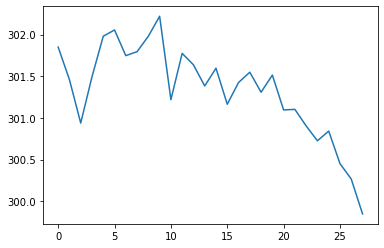

In [6]:
print(X.shape)
print(X[0,:,0:3])
%matplotlib inline
plt.plot(X[0,:,1])


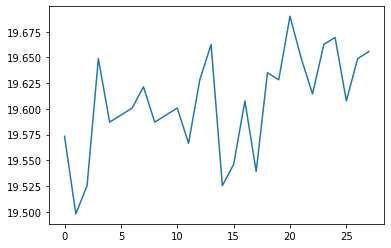

In [7]:
%matplotlib inline
plt.plot(X[2,:,2])


## Class array

In [8]:
print(y.shape)
print(y[0:5])

(289,)
[0. 0. 1. 1. 1.]


In [9]:
np.concatenate((y,), axis=0)[0:5]

array([0., 0., 1., 1., 1.])

In [10]:
y.reshape(-1,1)[0:5]

array([[0.],
       [0.],
       [1.],
       [1.],
       [1.]])

## Class array onehot encoded
Note that ```yoh[1]``` corresponds to the original class array. SHAP values will be computed for both model inputs, the ones corresponding to the original class labels will be in index ```[1]```-

In [11]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(np.concatenate((y,), axis=0).reshape(-1, 1))
yoh = enc.transform(y.reshape(-1, 1)).toarray()
print(yoh[0:5])

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


# Test scaling

get_standard_scaling
(289, 28, 5)
(5,)
(5,)
[ 6.86663121e-02  3.57286334e+02  1.72903288e+01  3.42911147e+00
 -2.26079082e-03]
apply_standard_scaling
(289, 28, 5)
(5,)
(5,)
(289, 28, 5)
[[ 0.87180386 -0.38415371  0.3424533 ]
 [ 5.27266177 -0.38686164  0.38317421]
 [ 3.02475564 -0.39047222  0.36281376]
 [ 2.11071153 -0.38662411  0.33690045]
 [ 0.4545376  -0.38325107  0.34430425]
 [ 4.01888266 -0.38272848  0.3572609 ]
 [ 8.18582453 -0.38486633  0.36466471]
 [ 4.42642364 -0.38453377  0.37947231]
 [ 3.47720486 -0.38325107  0.39057801]
 [ 5.5722112  -0.3815883   0.37762136]
 [ 0.49519764 -0.38852441  0.36651566]
 [ 0.14323015 -0.38467629  0.38132326]
 [ 3.25984313 -0.38562645  0.37021756]
 [-0.19027395 -0.38738423  0.35911186]
 [ 3.73200499 -0.38591149  0.36836661]
 [ 5.96341101 -0.38890447  0.353559  ]
 [ 7.40076668 -0.38709918  0.36836661]
 [ 1.4413098  -0.38624405  0.37762136]
 [ 2.10826489 -0.38790681  0.36836661]
 [ 1.26311088 -0.38648158  0.36281376]
 [ 3.29010018 -0.38937955  0.36281

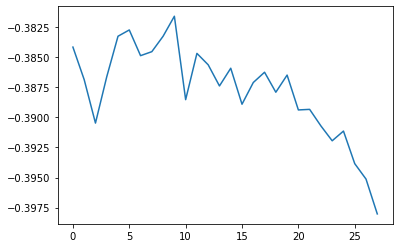

In [12]:
mean, std = get_standard_scaling(X)
print(mean)
X_scaled = apply_standard_scaling(X, mean, std)
print(X_scaled[0,:,0:3])
plt.plot(X_scaled[0,:,1])

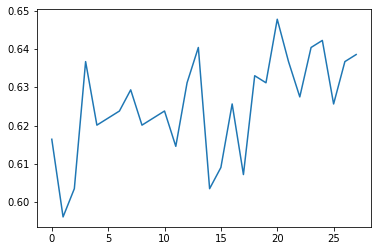

In [13]:
plt.plot(X_scaled[2,:,2])


# Test augmentation

In [14]:
from tsaug import AddNoise, Drift, Dropout, Pool, Quantize, TimeWarp

print(X.shape)
print(X[0][0])

X_aug = AddNoise(scale=0.1).augment(X)

print(X_aug.shape)
print(X_aug[0][0])

my_aug = (
    AddNoise(scale=0.1) * 3
    #+ Dropout(p=0.5) * 1
    #+ Pool() * 1
#    + Quantize(n_levels=5) * 2
)

# this is how many new instances we get (have to multiply y accordingly)
m = np.prod(np.asarray([5,2, 2, 2]))
m = np.prod(np.asarray([5]))
m = np.prod(np.asarray([3, 2]))
m = np.prod(np.asarray([3]))
m = m.astype(int)
print(m)

X_aug = my_aug.augment(X)
# add the original X
#X_aug = np.concatenate((X, X_aug.copy()))
print('X_aug.shape: ' + str(X_aug.shape))
print(X_aug[0][0])

y_aug = np.repeat(y, m)
print(y.shape)
print(y_aug.shape)
print(y[0:10])
print(y_aug[0:m*10])


(289, 28, 5)
[1.17853868e-01 3.01848958e+02 1.85587610e+01 1.77395264e+00
 1.23387391e+00]
(289, 28, 5)
[1.96926225e-01 3.01858486e+02 1.85298187e+01 1.88384756e+00
 3.13503981e+00]
3
X_aug.shape: (867, 28, 5)
[1.45387151e-01 3.01922345e+02 1.85501920e+01 1.81890920e+00
 8.15380000e-01]
(289,)
(867,)
[0. 0. 1. 1. 1. 1. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0.]


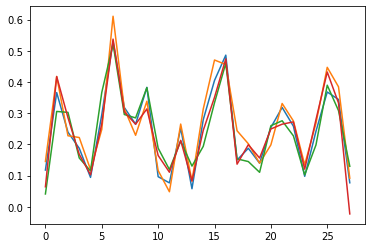

In [15]:
# instance
k = 0
# feature
f = 0

# the original
plt.plot(X[k,:,f])
for i in range(m):
    # augmentations
    plt.plot(X_aug[k+i,:,f])


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


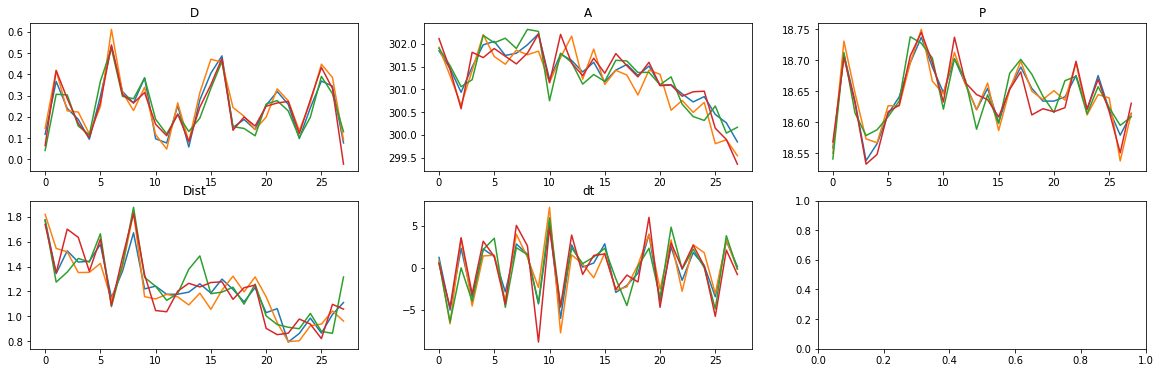

In [16]:
# instance
k = 0
# feature
f = 0

nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows, ncols)
fig.set_size_inches(20,6)

nsubs = len(features) - 2
for r in range(nrows):
    for c in range(ncols):
        f = r*ncols + c
        if f >= X_aug.shape[2]:
            continue
        # the original time series
        axs[r,c].plot(X[k,:,f])
        axs[r,c].set_title(features[f])
        for i in range(m):
            # augmentations
            axs[r,c].plot(X_aug[k+i,:,f])


In [17]:
X2 = np.append(X, X_aug, axis=0)
y2 = np.append(y, y_aug, axis=0)
print(X2.shape)
print(y2.shape)

(1156, 28, 5)
(1156,)


# Repeat cross-validation with InceptionTime

In [18]:
# parameters
use_bottleneck=True
kernel_size = 20
kernels = [3,8,17]
epochs = 20
repeats = 1
augment_data = False
job_name = "shap_inceptiontime"
job_id = "1"
now = datetime.now().strftime("%Y%m%d%H%M%S")
save_shap_values = True
set_split_random_state = False
verbose = True

# output folders
output_shap = Path(paths["output"]["shap"]) / job_name / now
output_shap.mkdir(parents=True, exist_ok=True)
output_it = Path(paths["output"]["it"]) / job_id
output_it.mkdir(parents=True, exist_ok=True)
output_it = str(output_it) + "/"

print(output_shap)
!ls $output_shap
os.listdir(output_shap)

/wrk/group/lmu/projects/n_track_ML/output/shap/shap_inceptiontime/20230127103444


[]

In [18]:
import time

tic = time.perf_counter()
repeat_output = inceptiontime_cv_repeat(X, y, groups, features, output_it, fset, \
                                        use_bottleneck=use_bottleneck, \
                                        kernel_size=kernel_size, \
                                        kernels = kernels, \
                                        epochs=epochs, \
                                        repeats=repeats, \
                                        job_id=job_id, \
                                        save_shap_values=save_shap_values, \
                                        augment_data=augment_data, \
                                        verbose=verbose)
scores, shap_lists_all = repeat_output
toc = time.perf_counter()

print(f"InceptionTime run in {toc - tic:0.2f} seconds")


Index(['D', 'A', 'P', 'Dist', 'dt'], dtype='object')
input_shape
(28, 5)
StratifiedGroupKFold(n_splits=4, random_state=None, shuffle=True)
repeat: 1/1
check shapes 1
X_train.shape: (221, 28, 5)
y_train.shape: (221,)
X_val.shape: (68, 28, 5)
y_val.shape: (68,)
truth.shape: (68,)
get_standard_scaling
(221, 28, 5)
(5,)
(5,)
apply_standard_scaling
(221, 28, 5)
(5,)
(5,)
(221, 28, 5)
check shapes 2
X_train.shape: (221, 28, 5)
X_train_scaled.shape: (221, 28, 5)
y_train.shape: (221,)
y_train.shape (one-hot): (221, 2)


2023-01-24 15:11:10.703616: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 5)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 28, 32)       160         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 28, 5)        0           ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 28, 32)       3072        ['conv1d[0][0]']                 
                                                                                              

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


check shapes 1
X_train.shape: (215, 28, 5)
y_train.shape: (215,)
X_val.shape: (74, 28, 5)
y_val.shape: (74,)
truth.shape: (74,)
get_standard_scaling
(215, 28, 5)
(5,)
(5,)
apply_standard_scaling
(215, 28, 5)
(5,)
(5,)
(215, 28, 5)
check shapes 2
X_train.shape: (215, 28, 5)
X_train_scaled.shape: (215, 28, 5)
y_train.shape: (215,)
y_train.shape (one-hot): (215, 2)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 5)]      0           []                               
                                                                                                  
 conv1d_32 (Conv1D)             (None, 28, 32)       160         ['input_2[0][0]']                
                                                                                                  
 max_pooling1d_6 (MaxPoo

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


check shapes 1
X_train.shape: (217, 28, 5)
y_train.shape: (217,)
X_val.shape: (72, 28, 5)
y_val.shape: (72,)
truth.shape: (72,)
get_standard_scaling
(217, 28, 5)
(5,)
(5,)
apply_standard_scaling
(217, 28, 5)
(5,)
(5,)
(217, 28, 5)
check shapes 2
X_train.shape: (217, 28, 5)
X_train_scaled.shape: (217, 28, 5)
y_train.shape: (217,)
y_train.shape (one-hot): (217, 2)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 5)]      0           []                               
                                                                                                  
 conv1d_64 (Conv1D)             (None, 28, 32)       160         ['input_3[0][0]']                
                                                                                                  
 max_pooling1d_12 (MaxPo

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


check shapes 1
X_train.shape: (214, 28, 5)
y_train.shape: (214,)
X_val.shape: (75, 28, 5)
y_val.shape: (75,)
truth.shape: (75,)
get_standard_scaling
(214, 28, 5)
(5,)
(5,)
apply_standard_scaling
(214, 28, 5)
(5,)
(5,)
(214, 28, 5)
check shapes 2
X_train.shape: (214, 28, 5)
X_train_scaled.shape: (214, 28, 5)
y_train.shape: (214,)
y_train.shape (one-hot): (214, 2)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 5)]      0           []                               
                                                                                                  
 conv1d_96 (Conv1D)             (None, 28, 32)       160         ['input_4[0][0]']                
                                                                                                  
 max_pooling1d_18 (MaxPo

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


len(list_shap_deep):4
len(list_shap_grad):4
InceptionTime run in 738.65 seconds


In [19]:
scores

,accuracy,precision,recall,f1,repeat,cv,classifier,fset,kernel_size,epochs,job_id
0,0.647059,0.695652,0.761905,0.727273,1.0,"StratifiedGroupKFold(n_splits=4, random_state=...",InceptionTime,all,20,20,1
1,0.540541,0.452381,0.633333,0.527778,1.0,"StratifiedGroupKFold(n_splits=4, random_state=...",InceptionTime,all,20,20,1
2,0.555556,0.695652,0.390244,0.500000,1.0,"StratifiedGroupKFold(n_splits=4, random_state=...",InceptionTime,all,20,20,1
3,0.573333,0.722222,0.325000,0.448276,1.0,"StratifiedGroupKFold(n_splits=4, random_state=...",InceptionTime,all,20,20,1


In [20]:
print(scores.accuracy.mean())

0.5791220632397104


# Save and load SHAP values

In [ ]:
from cv_inceptiontime import shap2npy

shap2npy(fset, shap_lists_all, output_shap)

In [ ]:
!ls $output_shap

In [ ]:
import os 
os.listdir(output_shap)

In [ ]:
list_idx_train = np.load(output_shap / 'list_idx_train.npy', allow_pickle=True)
list_idx_test = np.load(output_shap / 'list_idx_test.npy', allow_pickle=True)
list_X_test = np.load(output_shap / 'list_X_test.npy', allow_pickle=True)
list_shap_deep = np.load(output_shap / 'list_shap_deep.npy', allow_pickle=True)
list_shap_grad = np.load(output_shap / 'list_shap_grad.npy', allow_pickle=True)
list_accuracy = np.load(output_shap / 'list_accuracy.npy', allow_pickle=True)
features_load = np.load(output_shap / 'features.npy', allow_pickle=True)

In [ ]:
print(list_accuracy.mean())
print(list_idx_train.shape)
print(list_idx_train[0].shape)
print(list_idx_train[0])
print(list_idx_test[0])
print(list_shap_deep.shape)
print(list_shap_deep[0].shape)
print(list_shap_grad[0].shape)
print(list_shap_deep[0][0])


# Class distribution

In [ ]:
print(y[y==0].shape)
print(y[y==1].shape)



In [ ]:
np.save(output_shap / 'y_mean.npy', y)

In [ ]:
y_max = np.load('/wrk-vakka/group/lmu/projects/n_track_ML/output/shap/shap_inceptiontime/20221117135226/y_max.npy')
y_mean = np.load('/wrk-vakka/group/lmu/projects/n_track_ML/output/shap/shap_inceptiontime/20221117140251/y_mean.npy')


In [ ]:
np.sum(y_max - y_mean)

In [ ]:
y_max - y_mean

In [ ]:
y_max


In [ ]:
y_mean